In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import seaborn as sns

In [3]:
raw_data = pd.read_csv("Index2018.csv", parse_dates = ["date"])

In [3]:
raw_data

,date,spx,dax,ftse,nikkei
0,1994-07-01,469.900000,2224.95,3445.980000,18124.01
1,1994-10-01,475.270000,2225.00,3440.580000,18443.44
2,1994-11-01,474.130000,2228.10,3413.770000,18485.25
3,1994-12-01,474.170000,2182.06,3372.020000,18793.88
4,1994-01-13,472.470000,2142.37,3360.010000,18577.26
...,...,...,...,...,...
6264,2018-01-23,2839.130362,13559.60,7731.827774,24124.15
6265,2018-01-24,2837.544008,13414.74,7643.428966,23940.78
6266,2018-01-25,2839.253031,13298.36,7615.839954,23669.49
6267,2018-01-26,2872.867839,13340.17,7665.541292,23631.88


In [42]:
df = raw_data.copy()

In [5]:
df.describe()

,spx,dax,ftse,nikkei
count,6269.000000,6269.000000,6269.000000,6269.000000
mean,1288.127542,6080.063363,5422.713545,14597.055700
std,487.586473,2754.361032,1145.572428,4043.122953
min,438.920000,1911.700000,2876.600000,7054.980000
25%,990.671905,4069.350000,4486.100000,10709.290000
50%,1233.420000,5773.340000,5662.430000,15028.170000
75%,1459.987747,7443.070000,6304.250000,17860.470000
max,2872.867839,13559.600000,7778.637689,24124.150000


In [6]:
df.isna().sum()

date      0
spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

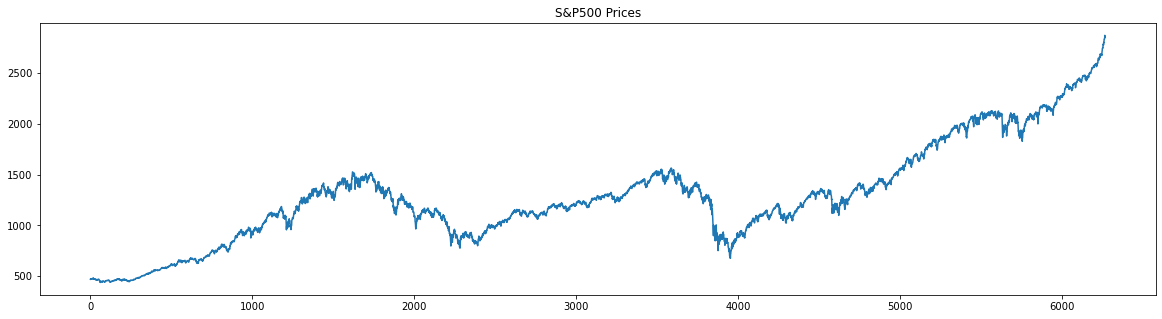

In [11]:
df.spx.plot(figsize=(20,5), title = "S&P500 Prices")
plt.show()

### QQ Plot ( QQ Plot shows if data is normally distributed. If the data follows red line it is normally distributed. Since quite some data is on 500, this time series data is not normally distributed.

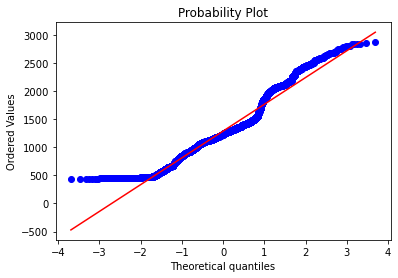

In [13]:
scipy.stats.probplot(df.spx, plot=pylab)
pylab.show()

In [14]:
df.date.describe()

count                    6269
unique                   6269
top       1999-08-23 00:00:00
freq                        1
first     1994-01-02 00:00:00
last      2018-12-01 00:00:00
Name: date, dtype: object

In [6]:
df.set_index("date", inplace= True)


In [7]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-07-01,469.90,2224.95,3445.98,18124.01
1994-10-01,475.27,2225.00,3440.58,18443.44
1994-11-01,474.13,2228.10,3413.77,18485.25
1994-12-01,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


### Setting time frequency of data - h = hourly, w = weekly, d = daily, m= monthly, a = annual, b=business days. This will handle any missing data and introduce NaN values for missing dates to set constant time frequency. Since this dataset contains only business date readings, we use b

In [8]:
df = df.asfreq('B')

In [33]:
df.head()

,spx,dax,ftse,nikkei
date,,,,
1994-07-01,469.90,2224.95,3445.98,18124.01
1994-07-04,450.88,2184.89,3129.00,19890.98
1994-07-05,NaN,NaN,NaN,NaN
1994-07-06,458.21,2131.80,3004.80,21042.71
1994-07-07,448.38,2049.10,2964.40,20620.02


In [38]:
df.isna().sum()

spx         0
dax       686
ftse        0
nikkei    686
dtype: int64

### Handling missing data via front filling or back filling

In [9]:
df.spx = df.spx.fillna(method = "ffill")

In [10]:
df.ftse = df.ftse.fillna(method = "bfill")

In [11]:
df.dax = df.dax.fillna(value = df.dax.mean())

In [12]:
df.nikkei = df.nikkei.fillna(method = "ffill")

In [13]:
df['mkt_val'] = df.spx

In [16]:
df.head()

,spx,mkt_val
date,,
1994-07-01,469.90,469.90
1994-07-04,450.88,450.88
1994-07-05,450.88,450.88
1994-07-06,458.21,458.21
1994-07-07,448.38,448.38


In [15]:
del df['dax'], df['ftse'], df['nikkei']

In [17]:
size = int(len(df)*0.8)

In [18]:
df_train = df.iloc[:size]

In [19]:
df_test = df.iloc[size:]

In [20]:
df_train.tail()

,spx,mkt_val
date,,
2013-05-06,1608.898667,1608.898667
2013-05-07,1631.886903,1631.886903
2013-05-08,1707.137145,1707.137145
2013-05-09,1655.077451,1655.077451
2013-05-10,1655.077451,1655.077451


In [51]:
df_test.head()

,mkt_val
date,
2013-05-13,1633.766242
2013-05-14,1650.339864
2013-05-15,1658.784662
2013-05-16,1650.473712
2013-05-17,1667.471448


### Stationarity

In [53]:
sts.adfuller(df_train.mkt_val)

(-1.6778004834242133,
 0.442585096021205,
 23,
 4897,
 {'1%': -3.43168606925165,
  '5%': -2.862130395401403,
  '10%': -2.5670842686576476},
 50987.24519670836)

### As per Dickey-Fuller test, if test statistic (-1.677800 in this case) is < threshold (5% = -2.862 in this case) then we reject the null hypothesisand conclude that sample comes from stationary dataset. Since that is not the case here, we cannot prove that data is stationary. The second value (0.442585) represents the p-value

### ACF

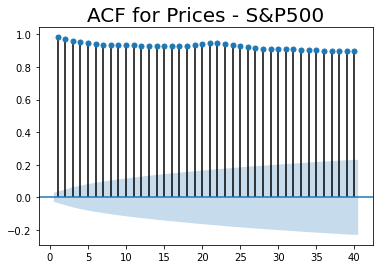

In [56]:
sgt.plot_acf(df_train.mkt_val, zero = False, lags = 40 )
plt.title("ACF for Prices - S&P500", size = 20)
plt.show()

### PACF

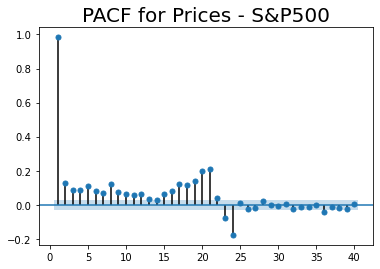

In [57]:
sgt.plot_pacf(df_train.mkt_val, zero = False, lags = 40, alpha = 0.05, method = ('ols') )
plt.title("PACF for Prices - S&P500", size = 20)
plt.show()

### As visible from PACF graph, co-efficients from lag 25 onwards are too close to zero and hence their impact on the model is minimal. Hence we can ignore them. There are negative co-efficients from lag 22 onwards. This is because there are roughly 22 business days in a month and the graph indicates there are cyclical changes every month. The values a month ago, negatively affect the values today. However the most impact to the model is from lag 1. 

#### The AR(1) Model

In [24]:
model_ar = ARMA(df_train.mkt_val, order = (1,0))  
### here 0 represents that we are not taking residuals under consideration

In [25]:
results_ar = model_ar.fit()

In [26]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                mkt_val   No. Observations:                 4921
Model:                     ARMA(1, 0)   Log Likelihood              -26298.962
Method:                       css-mle   S.D. of innovations             50.650
Date:                Mon, 15 Nov 2021   AIC                          52603.923
Time:                        10:59:35   BIC                          52623.427
Sample:                    07-01-1994   HQIC                         52610.764
                         - 05-10-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1108.2823     45.442     24.389      0.000    1019.217    1197.347
ar.L1.mkt_val     0.9843      0.003    385.203      0.000       0.979       0.989
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0159           +0.0000j            1.0159            0.0000
-----------------------------------------------------------------------------
"""

In [27]:
model_ar2 = ARMA(df_train.mkt_val, order = (2,0))  
results_ar2 = model_ar2.fit()
results_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                mkt_val   No. Observations:                 4921
Model:                     ARMA(2, 0)   Log Likelihood              -26258.760
Method:                       css-mle   S.D. of innovations             50.238
Date:                Mon, 15 Nov 2021   AIC                          52525.519
Time:                        10:59:40   BIC                          52551.525
Sample:                    07-01-1994   HQIC                         52534.641
                         - 05-10-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1108.2737     52.111     21.268      0.000    1006.139    1210.409
ar.L1.mkt_val     0.8591      0.014     60.771      0.000       0.831       0.887
ar.L2.mkt_val     0.1274      0.014      9.004      0.000       0.100       0.155
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0121           +0.0000j            1.0121            0.0000
AR.2           -7.7554           +0.0000j            7.7554            0.5000
-----------------------------------------------------------------------------
"""

In [28]:
model_ar4 = ARMA(df_train.mkt_val, order = (4,0))  
results_ar4 = model_ar4.fit()
results_ar4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                mkt_val   No. Observations:                 4921
Model:                     ARMA(4, 0)   Log Likelihood              -26220.708
Method:                       css-mle   S.D. of innovations             49.850
Date:                Mon, 15 Nov 2021   AIC                          52453.416
Time:                        10:59:43   BIC                          52492.424
Sample:                    07-01-1994   HQIC                         52467.099
                         - 05-10-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1109.0954     63.297     17.522      0.000     985.036    1233.155
ar.L1.mkt_val     0.8404      0.014     59.197      0.000       0.813       0.868
ar.L2.mkt_val     0.0484      0.019      2.608      0.009       0.012       0.085
ar.L3.mkt_val     0.0112      0.019      0.601      0.548      -0.025       0.048
ar.L4.mkt_val     0.0891      0.014      6.269      0.000       0.061       0.117
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0082           -0.0000j            1.0082           -0.0000
AR.2            0.6255           -2.0684j            2.1609           -0.2033
AR.3            0.6255           +2.0684j            2.1609            0.2033
AR.4           -2.3845           -0.0000j            2.3845           -0.5000
-----------------------------------------------------------------------------
"""

### Since log likelihood has been increasing with each model and information criteria (AIC, BIC & HQIC) has been decreasing (this is desired), we need to do the log likelihood ratio test to identify which is the best model out ot the 3 (model_ar1, model_ar2, model_ar4) or if the 3 models are significantly different

In [32]:
def LLR (model_1, model_2, DF = 1):  ### DF is degrees of freedom
    L1 = model_1.fit().llf
    L2 = model_2.fit().llf
    LR = 2*(L2-L1)
    p = chi2.sf(LR, DF).round(5)
    return p
    

In [33]:
LLR(model_ar, model_ar2)

0.0

In [34]:
LLR(model_ar2, model_ar4)

0.0

### This shows that models are significantly different from each other (p value is less)

### We continue with higher models till 2 conditions are satisfied - 
### 1. non-significant p-value for LLR Test 
### 2. non-significant p-value for highest lag co-efficients

In [39]:
model_ar14 = ARMA(df_train.mkt_val, order = (14,0))  
results_ar14 = model_ar14.fit()
results_ar14.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                mkt_val   No. Observations:                 4921
Model:                    ARMA(14, 0)   Log Likelihood              -26077.031
Method:                       css-mle   S.D. of innovations             48.412
Date:                Mon, 15 Nov 2021   AIC                          52186.062
Time:                        11:10:01   BIC                          52290.082
Sample:                    07-01-1994   HQIC                         52222.549
                         - 05-10-2013                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1099.7866    153.236      7.177      0.000     799.450    1400.123
ar.L1.mkt_val      0.7826      0.014     54.924      0.000       0.755       0.810
ar.L2.mkt_val      0.0363      0.018      2.005      0.045       0.001       0.072
ar.L3.mkt_val     -0.0040      0.018     -0.219      0.827      -0.039       0.032
ar.L4.mkt_val     -0.0136      0.018     -0.749      0.454      -0.049       0.022
ar.L5.mkt_val      0.0374      0.018      2.066      0.039       0.002       0.073
ar.L6.mkt_val      0.0146      0.018      0.807      0.420      -0.021       0.050
ar.L7.mkt_val     -0.0379      0.018     -2.096      0.036      -0.073      -0.002
ar.L8.mkt_val      0.0578      0.018      3.198      0.001       0.022       0.093
ar.L9.mkt_val      0.0228      0.018      1.259      0.208      -0.013       0.058
ar.L10.mkt_val     0.0149      0.018      0.824      0.410      -0.021       0.050
ar.L11.mkt_val     0.0073      0.018      0.402      0.687      -0.028       0.043
ar.L12.mkt_val     0.0366      0.018      2.021      0.043       0.001       0.072
ar.L13.mkt_val     0.0141      0.018      0.779      0.436      -0.021       0.050
ar.L14.mkt_val     0.0271      0.014      1.903      0.057      -0.001       0.055
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0015           -0.0000j            1.0015           -0.0000
AR.2             1.0421           -0.4872j            1.1504           -0.0696
AR.3             1.0421           +0.4872j            1.1504            0.0696
AR.4             0.8287           -0.9717j            1.2771           -0.1376
AR.5             0.8287           +0.9717j            1.2771            0.1376
AR.6             0.2991           -1.2679j            1.3027           -0.2131
AR.7             0.2991           +1.2679j            1.3027            0.2131
AR.8            -1.3010           -0.0000j            1.3010           -0.5000
AR.9            -1.2118           -0.6683j            1.3838           -0.4198
AR.10           -1.2118           +0.6683j            1.3838            0.4198
AR.11           -0.7817           -1.0886j            1.3402           -0.3491
AR.12           -0.7817           +1.0886j            1.3402            0.3491
AR.13           -0.2863           -1.4710j            1.4986           -0.2806
AR.14           -0.2863           +1.4710j            1.4986            0.2806
------------------------------------------------------------------------------
"""

In [40]:
model_ar15 = ARMA(df_train.mkt_val, order = (15,0))  
results_ar15 = model_ar15.fit()
print(results_ar15.summary())
print("LLR - " + str(LLR(model_ar14, model_ar15)))

                              ARMA Model Results                              
Dep. Variable:                mkt_val   No. Observations:                 4921
Model:                    ARMA(15, 0)   Log Likelihood              -26067.046
Method:                       css-mle   S.D. of innovations             48.314
Date:                Mon, 15 Nov 2021   AIC                          52168.093
Time:                        11:11:04   BIC                          52278.614
Sample:                    07-01-1994   HQIC                         52206.860
                         - 05-10-2013                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1099.2308    167.749      6.553      0.000     770.449    1428.013
ar.L1.mkt_val      0.7808      0.014     54.893      0.000       0.753       0.809
ar.L2.mkt_val      0.0354      0.018

### AR models work best with stationary time series so for non-stationary time series we will have to turn the series into stationary 

In [43]:
sts.adfuller(df.ftse)

(-1.5942821597949672,
 0.4864651302056871,
 6,
 6262,
 {'1%': -3.4313947113763845,
  '5%': -2.862001669939781,
  '10%': -2.5670157439442236},
 68396.51796279417)

In [45]:
df['returns'] = df.ftse.pct_change(1).mul(100)
df = df.iloc[1:]

In [47]:
df.head

<bound method NDFrame.head of            date          spx       dax         ftse    nikkei   returns
1    1994-10-01   475.270000   2225.00  3440.580000  18443.44 -0.156704
2    1994-11-01   474.130000   2228.10  3413.770000  18485.25 -0.779229
3    1994-12-01   474.170000   2182.06  3372.020000  18793.88 -1.222988
4    1994-01-13   472.470000   2142.37  3360.010000  18577.26 -0.356166
5    1994-01-14   474.910000   2151.05  3400.560000  18973.70  1.206842
...         ...          ...       ...          ...       ...       ...
6264 2018-01-23  2839.130362  13559.60  7731.827774  24124.15  0.212382
6265 2018-01-24  2837.544008  13414.74  7643.428966  23940.78 -1.143311
6266 2018-01-25  2839.253031  13298.36  7615.839954  23669.49 -0.360951
6267 2018-01-26  2872.867839  13340.17  7665.541292  23631.88  0.652605
6268 2018-01-29  2853.528411  13324.48  7671.533300  23629.34  0.078168

[6268 rows x 6 columns]>

In [48]:
sts.adfuller(df.returns)

(-15.182022490939042,
 6.178382600319799e-28,
 34,
 6233,
 {'1%': -3.4313995740622145,
  '5%': -2.8620038184370746,
  '10%': -2.567016887640913},
 19014.128593790985)

### As we can see from the p-value as well as test statistic, the series is now converted to stationary